In [3]:
import numpy as np
import scipy.linalg
import scipy.io
%matplotlib inline

def trans_cov(dat, cov, mean=np.array([[0],[0]])):
    evals, evecs = scipy.linalg.eigh(cov)
    c = np.dot(evecs, np.diag(np.sqrt(evals)))
    res = np.dot(c,dat)
    if not np.allclose(np.round(np.cov(res)), cov):
        print(np.cov(res))
    res = res + mean
    assert np.allclose(np.round(np.mean(res, axis=1)), mean.T[0])
    
    return res

In [4]:
dats = [
            [trans_cov(np.random.randn(2, 200), np.eye(2)),
             trans_cov(np.random.randn(2, 200), np.eye(2), np.array([[3],[0]]))],
    
            [trans_cov(np.random.randn(2, 200), np.array([[4,3],[3,4]]), np.array([[-1],[0]])),
             trans_cov(np.random.randn(2, 200), np.array([[4,3],[3,4]]), np.array([[1],[0]]))],
    
            [trans_cov(np.random.randn(2, 200), np.array([[3,1],[1,2]])),
             trans_cov(np.random.randn(2, 200), np.array([[7,-3],[-3,4]]), np.array([[3],[0]]))]
        ]

In [5]:
dats.append([scipy.io.loadmat("case4.mat")["a"], scipy.io.loadmat("case4.mat")["b"]])

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

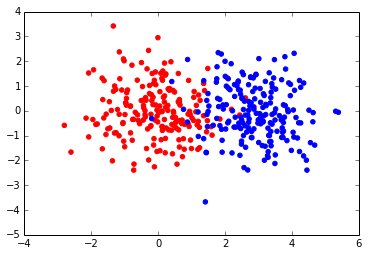

In [143]:
dat = dats[0]
fig = plt.figure()
plt.scatter(dat[0][0], dat[0][1], color="red")
plt.scatter(dat[1][0], dat[1][1], color="blue")
plt.show()

In [133]:
def med(c1, c2):
    """Create an med function"""
    z1 = np.mean(c1, axis=1)
    z2 = np.mean(c2, axis=1)
    def f(x):
        return -np.dot(z1,x) + 0.5*np.dot(z1.T,z1) < -np.dot(z2,x) + 0.5*np.dot(z2.T,z2)
    return f

In [134]:
af = med(dat[0], dat[1])

In [137]:
res1 = af(dat[0])
res2 = af(dat[1])

In [16]:
def ged(c1, c2):
    # transform each class to have have perfect covariance
    c1_mod = trans_cov(c1, np.array([[1,0],[0,1]]), np.array([np.mean(c1, axis=1)]).T)
    c2_mod = trans_cov(c2, np.array([[1,0],[0,1]]), np.array([np.mean(c2, axis=1)]).T)
    # then do the usual med
    return med(c1_mod, c2_mod)

In [139]:
np.cov(dat[0])

array([[ 0.95775183, -0.05674961],
       [-0.05674961,  1.09919095]])

In [17]:
from numpy.linalg import norm, inv

def map_class(c1, c2):
    e1 = np.cov(c1)
    e2 = np.cov(c2)
    u1 = np.mean(c1, axis=1)
    u2 = np.mean(c2, axis=1)
    
    def f(x):
        #ipdb.set_trace()
        return np.log(np.sqrt(norm(e2))/np.sqrt(norm(e1))) \
               -0.5*np.dot(np.dot((x - u1),inv(e1)),(x - u1).T) \
               +0.5*np.dot(np.dot((x - u2),inv(e2)),(x - u2).T) \
                < 0
    return f

In [10]:
def knn(c1, c2, k):
    # initiaslise with K points from each class
    zero_shape = (c1.shape[0], c1.shape[1]*2)
    c1_res = np.zeros(zero_shape)
    c1_count = 0
    c2_res = np.zeros(zero_shape)
    c2_count = 0
    c_all = np.concatenate((c1, c2), axis=1)

    # because numpy nditer is psychotic
    for c_ind in xrange(c_all.shape[1]):
        val = c_all[:, c_ind]
        #find the nearest K neighbours
        print(val)
        if np.allclose(val, np.array([-2, 0])):
            ipdb.set_trace()
        ind = np.argpartition(norm(c_all.T - val, axis=1), k+1)[:k+1][1:k+1]
        
        # class the point where the majority of the neighbours are
        sort_res = 0
        for ix in ind:
            if ix < c1.shape[1]:
                sort_res += 1
            else:
                sort_res -= 1

        if sort_res > 0:
            c1_res[:, c1_count] = val
            c1_count += 1
        else:
            c2_res[:, c2_count] = val
            c2_count += 1

    assert c1_count + c2_count == c1.shape[1] + c1.shape[1]
    return (c1_res[:, :c1_count], c2_res[:, :c2_count])

[-0.63372214 -0.62298086]
[ 0.54341718 -0.25625298]
[-1.82060597 -0.07304248]
[ 2.99610009 -2.10944224]
[-0.28628599 -0.21907912]
[-1.09683092  1.60244057]
[ 2.54350454  0.24094445]
[ 0.26567629 -0.86511157]
[-0.37030257  0.528623  ]
[ -1.66136706e+00  -1.07864034e-03]
[ 0.23618972 -1.26013363]
[-2.18249921  0.97404858]
[-1.11972953  1.94483224]
[-0.57202361 -0.99964646]
[ 0.31057998  0.38254817]
[ 1.22411631 -0.08658691]
[-1.39789167  0.37899286]
[-0.47078607  0.09629935]
[-0.44615289  0.75444113]
[-0.04351567 -0.42501836]
[ 0.52953547  0.38002562]
[-0.53200369  0.09690776]
[ 0.78744642  0.95570913]
[-0.3151488  -0.65102365]
[-0.44632163  0.34334542]
[ 1.02223992 -0.24656335]
[-0.0283358   0.16621876]
[-0.96546065 -1.51807179]
[-2.35505121 -0.27923164]
[ 0.93230465 -1.1135235 ]
[-0.51826552 -0.21075109]
[ 0.51135281  0.84331584]
[-1.58168573 -0.01226449]
[-1.58668265  1.25164522]
[ 0.56634468 -0.95796235]
[-0.71234592  0.52669988]
[-0.83999755  0.68852855]
[ 0.0647848  1.2423845]
[ 0.

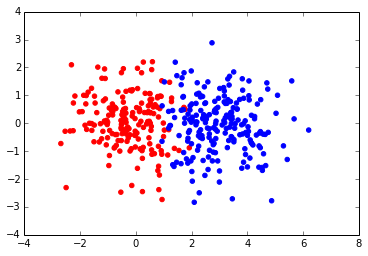

In [14]:
# make for-loop later
dat = dats[0]
fig = plt.figure()
res_1, res_2 = knn(dat[0], dat[1], 3)
plt.scatter(res_1[0], res_1[1], color="red")
plt.scatter(res_2[0], res_2[1], color="blue")
plt.show()

In [15]:
# get the map class working
map_func = map_class(dat[0], dat[1])
res = map_func(np.concatenate((dat[0], dat[1]), axis=1))
# make a countour plot

UnboundLocalError: local variable 'u1' referenced before assignment